In [1]:
# load dataset
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import simplejson as json
import numpy as np

df = pd.read_csv("/users/akuppam/documents/Hprog/Py/rnb1015_2.csv")
df.head(5)

,date,region,marketing,visits,br,inq,gb,cb,nb,ss,ts,listings
0,1/1/16,AMR,NotPaid,1256288,6043,66022,6071,571,5500,485968.08000,144695.894200,10242216
1,1/1/16,AMR,Paid,189297,1092,11806,743,2,741,0.00000,14138.809600,2133795
2,1/1/16,UK,NotPaid,201797,435,9662,436,33,403,72698.92472,8317.105056,3561696
3,1/1/16,UK,Paid,55934,88,2749,61,1,60,0.00000,815.336426,890424
4,1/1/16,CE,NotPaid,200786,573,9250,435,31,404,40490.73159,12016.782410,3062480


In [2]:
df = pd.read_csv("/users/akuppam/documents/Hprog/Py/rnb1015_2.csv")
df = df.loc[(df['region'] == 'UK') & (df['marketing'] == 'NotPaid')]
df = df[~(df['nb'] < 0)]
df.describe()
df.index = pd.to_datetime(df.date)
cols = ["nb"]
y = df[cols]
y.head()

,nb
date,
2016-01-01,403
2016-01-02,451
2016-01-03,682
2016-01-04,672
2016-01-05,705


In [3]:
'''
t Trend: Additive
d Damped: False
s Seasonal: Additive
p Seasonal Periods: 12
b Box-Cox Transform: False
r Remove Bias: True
'''

'\nt Trend: Additive\nd Damped: False\ns Seasonal: Additive\np Seasonal Periods: 12\nb Box-Cox Transform: False\nr Remove Bias: True\n'

In [6]:
# going back to the original code
# make changes to params
# expt w/ n_test
# finalize this
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from numpy import array
 
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, hw_params):
	t,d,s,p,b,r = hw_params
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, params):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, params)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 
# score a model, return None on failure
def score_model(data, n_test, params, debug=False):
	result = None
	# convert params to a key
	key = params
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, params)
	else:
		# one failure during model validation suggests unstable params
		try:
			# never show warnings when grid searching
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, params)
		except:
			error = None
	# check results
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search params
def grid_search(data, params_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, params) for params in params_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, params) for params in params_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort params by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 
# create a set of exponential smoothing params
def exp_smoothing_params(seasonal=[None]):
	models = list()
	# define params lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create params instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							params = [t,d,s,p,b,r]
							models.append(params)
	return models
 
if __name__ == '__main__':
	# load dataset
	df.index = pd.to_datetime(df.date)
	cols = ["nb"]
	y = df[cols]
	series_y = y['nb'].iloc[:,]
	data = series_y.values
	# data split
	n_test = 200
	# model params
	params_list = exp_smoothing_params(seasonal=[1,7,365])
	# grid search
	scores = grid_search(data, params_list, n_test)
	print('done')
	# list top 3 params
	for params, error in scores[:1]:
		print(params, error)

with open('model_params.json','w') as out_params:
        json.dump(params, out_params)

with open('model_params.json') as json_file:
    out_params = json.load(json_file)

t = out_params[0]
d = out_params[1]
s = out_params[2]
p = out_params[3]
b = out_params[4]
r = out_params[5]

model = ExponentialSmoothing(series_y, trend=t, damped=d, seasonal=s, seasonal_periods=p)
model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
predictions = model_fit.fittedvalues
yhat = model_fit.forecast(442)
series_hw = predictions.append(yhat)

 > Model[[None, False, 'add', 7, True, True]] 82.008
 > Model[['add', False, None, 7, True, True]] 117.334
 > Model[[None, False, 'add', 7, True, False]] 81.934
 > Model[['add', False, None, 7, True, False]] 117.320
 > Model[['add', False, None, 365, True, True]] 117.334
 > Model[['add', False, None, 365, True, False]] 117.320
 > Model[[None, False, 'add', 365, True, True]] 138.680
 > Model[['mul', False, 'add', 7, True, True]] 82.068
 > Model[[None, False, 'add', 365, True, False]] 138.282
 > Model[[None, False, 'mul', 7, True, True]] 81.620
 > Model[[None, False, 'mul', 7, True, False]] 81.552
 > Model[['mul', False, 'add', 7, True, False]] 82.027
 > Model[[None, False, 'mul', 365, True, True]] 140.944
 > Model[[None, False, 'mul', 365, True, False]] 140.684
 > Model[[None, False, None, 1, True, True]] 117.289
 > Model[[None, False, None, 1, True, False]] 117.228
 > Model[[None, False, None, 7, True, True]] 117.289
 > Model[[None, False, None, 7, True, False]] 117.228
 > Model[[None,

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:163: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [7]:
series_hw.to_csv("series_hw-w.csv")

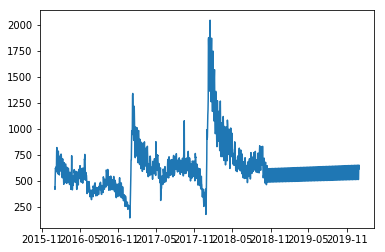

In [8]:
plt.plot(series_hw)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:163: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:713: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


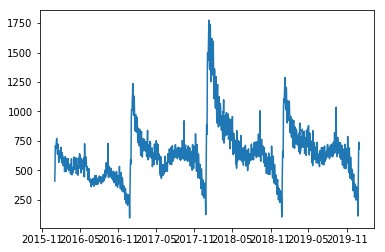

In [9]:
# best HW model (['add', False, 'mul', 7, True, False] 81.49152678204416)
t = 'add'
d = False
s = 'mul'
p = 365
b = True
r = False
model = ExponentialSmoothing(series_y, trend=t, damped=d, seasonal=s, seasonal_periods=p)
model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
predictions = model_fit.fittedvalues
yhat = model_fit.forecast(442)
series_hw = predictions.append(yhat)
plt.plot(series_hw)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:163: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


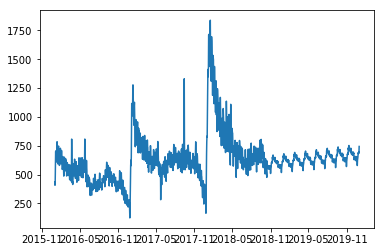

In [16]:
# best HW model ['add', False, 'mul', 7, True, False] 81.49152678204416
t = 'add'
d = False
s = 'mul'
p = 52
b = True
r = False
model = ExponentialSmoothing(series_y, trend=t, damped=d, seasonal=s, seasonal_periods=p)
model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
predictions = model_fit.fittedvalues
yhat = model_fit.forecast(442)
series_hw = predictions.append(yhat)
plt.plot(series_hw)

In [45]:
import warnings
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def HWFxn(df, fcstdays):

        series = df['y']
    
        # evaluate parameters
        t_params = ['add', 'mul', None]
        d_params = [True, False]
        s_params = ['add', 'mul', None]
        p_params = [365]
        b_params = [True, False]
        r_params = [True, False]
           
        best_score, best_params = float("inf"), None
        series = series.astype('double')
        for t in t_params:
            for d in d_params:
                for s in s_params:
                    for p in p_params:
                        for b in b_params:
                            for r in r_params:
                                params = (t,d,s,p,b,r)
                                try:
                                    mse = evaluate_hw_model(series, params, fcstdays)
                                    if mse < best_score:
                                        best_score, best_params = mse, params
                                    #print('HW MSE=%.3f' % (mse))
                                    #print('HW params', params)
                                except:
                                    continue
        # apply model
        model = ExponentialSmoothing(series, trend=params[0], damped=params[1], seasonal=params[2], seasonal_periods=params[3])
        model_fit = model.fit(optimized=True, use_boxcox=params[4], remove_bias=params[5])
        print(model_fit.summary())
    
        pred_fcst = model_fit.fittedvalues
        hw_forecast = model_fit.forecast(fcstdays)
        hw_series = pred_fcst.append(hw_forecast)
    
        return hw_series

    
def evaluate_hw_model(X, hw_params, fcstdays):
    (t,d,s,p,b,r) = hw_params
    # make predictions
    predictions = list()
    model = ExponentialSmoothing(X, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    predictions = model_fit.fittedvalues
    yhat = model_fit.forecast(fcstdays)
    # calculate out of sample error
    error = mean_squared_error(X, predictions)
    print('error = ', error)
    return error

In [46]:
df = pd.read_csv("/users/akuppam/documents/Hprog/Py/rnb1015_2.csv")
df = df.loc[(df['region'] == 'UK') & (df['marketing'] == 'NotPaid')]
df = df[~(df['nb'] < 0)]
df.describe()
df.index = pd.to_datetime(df.date)
cols = ["nb"]
df = df[cols]
df.columns = ['y']
df.head()

,y
date,
2016-01-01,403
2016-01-02,451
2016-01-03,682
2016-01-04,672
2016-01-05,705


In [47]:
HWFxn(df, 365)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7469.921628523252


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7508.323137462976


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  9563.310797410128


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  9564.712845635277


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7323.462501352966


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7358.892270395762


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  14237.749526362602


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  14271.328840629581


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13558.861012113673


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13566.184124091635


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13676.199125713381


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13676.28515049344


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  8221.44792391713


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  8225.971053833982


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  10282.059288237595


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  10282.176766500674


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7389.375539418955


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7399.011610530934


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7815.165131378179


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7815.165917828248


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13616.67151552888


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13624.069201422883


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13714.995961841598


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13714.995961862302


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  40626.22830593509


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  41047.21064411516


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13132.203446542619


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13133.045632357773


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7326.569774540481


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7359.541630180073


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:182: RuntimeWarning: invalid value encountered in double_scalars
  (alphac * (l[i - 1] * b[i - 1]**phi))
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:183: RuntimeWarning: invalid value encountered in double_scalars
  b[i] = (beta * (l[i] / l[i - 1])) + (betac * b[i - 1]**phi)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:185: RuntimeWarning: invalid value encountered in double_scalars
  b[i - 1]**phi)) + (gammac * s[i - 1])
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:186: RuntimeWarning: invalid value encountered in power
  return sqeuclidean((l * b**phi) * s[:-(m - 1)], y)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:670: Runtim

error =  13558.818970941515


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13566.159761706622


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13676.415650786312


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13676.495938646594


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  40704.32085475591


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  41149.86712676566


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  14773.291312741827


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  14780.508697329884


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  23242.944567223556


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  23356.27006046149


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  17217.26418703956


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  17347.85645076463


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13600.96696572262


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13615.045056956234


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  b[i] = (beta * (l[i] / l[i - 1])) + (betac * b[i - 1]**phi)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:70: RuntimeWarning: invalid value encountered in double_scalars
  b[i] = (beta * (l[i] / l[i - 1])) + (betac * b[i - 1]**phi)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  13660.81821447707


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  b[i] = (beta * (l[i] / l[i - 1])) + (betac * b[i - 1]**phi)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:70: RuntimeWarning: invalid value encountered in double_scalars
  b[i] = (beta * (l[i] / l[i - 1])) + (betac * b[i - 1]**phi)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/sit

error =  13806.56825553948
error =  7468.076954824886


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7506.011621433578


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  8073.597503337528


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  8074.7340967839145


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7323.461841609523


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  7358.891386477097


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  14094.127610513851


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


error =  14132.647039886562
error =  13612.555926995394
error =  13621.650239231883
error =  13714.996161122823
error =  13715.042258557414


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


None


2016-01-01    479.299085
2016-01-02    439.696443
2016-01-03    445.563495
2016-01-04    568.284629
2016-01-05    622.117551
2016-01-06    665.137254
2016-01-07    668.699326
2016-01-08    658.993539
2016-01-09    660.554027
2016-01-10    633.795178
2016-01-11    744.458028
2016-01-12    764.982082
2016-01-13    730.734427
2016-01-14    704.920032
2016-01-15    650.461837
2016-01-16    605.065227
2016-01-17    608.664685
2016-01-18    714.204819
2016-01-19    731.226987
2016-01-20    675.571379
2016-01-21    658.146330
2016-01-22    636.789542
2016-01-23    591.222838
2016-01-24    594.740489
2016-01-25    668.579546
2016-01-26    685.926258
2016-01-27    707.764414
2016-01-28    701.139112
2016-01-29    696.395503
2016-01-30    631.828667
                 ...    
2019-09-16    592.856995
2019-09-17    592.856995
2019-09-18    592.856995
2019-09-19    592.856995
2019-09-20    592.856995
2019-09-21    592.856995
2019-09-22    592.856995
2019-09-23    592.856995
2019-09-24    592.856995


In [103]:
import warnings
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def HWFxn(df, fcstdays):

        series = df['y']
    
        # evaluate parameters
        t_params = ['add', 'mul', None]
        d_params = [True, False]
        s_params = ['add', 'mul', None]
        p_params = [365]
        b_params = [True, False]
        r_params = [True, False]
           
        best_score, best_params = float("inf"), None
        series = series.astype('double')
        for t in t_params:
            for d in d_params:
                for s in s_params:
                    for p in p_params:
                        for b in b_params:
                            for r in r_params:
                                params = (t,d,s,p,b,r)
                                try:
                                    mse = evaluate_hw_model(series, params, fcstdays)
                                    if mse < best_score:
                                        best_score, best_params = mse, params
                                    #print('HW MSE=%.3f' % (mse))
                                    print('HW params', params)
                                except:
                                    continue
        # apply model
        model = ExponentialSmoothing(series, trend=params[0], damped=params[1], seasonal=params[2], seasonal_periods=params[3])
        model_fit = model.fit(optimized=True, use_boxcox=params[4], remove_bias=params[5])
        print(model_fit.summary())
    
        pred_fcst = model_fit.fittedvalues
        hw_forecast = model_fit.forecast(fcstdays)
        hw_series = pred_fcst.append(hw_forecast)
    
        return hw_series

    
def evaluate_hw_model(X, hw_params, fcstdays):
    (t,d,s,p,b,r) = hw_params
    # make predictions
    predictions = list()
    model = ExponentialSmoothing(X, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    predictions = model_fit.fittedvalues
    yhat = model_fit.forecast(fcstdays)
    # calculate out of sample error
    error = mean_squared_error(X, predictions)
    print('error = ', error)
    print('hw_params = ', hw_params)
    return error

In [104]:
HWFxn(df, 365)

error =  7469.818896496007
hw_params =  ('add', True, 'add', 365, True, True)
HW params ('add', True, 'add', 365, True, True)
error =  7508.208708015873
hw_params =  ('add', True, 'add', 365, True, False)
HW params ('add', True, 'add', 365, True, False)
error =  9562.550671785224
hw_params =  ('add', True, 'add', 365, False, True)
HW params ('add', True, 'add', 365, False, True)
error =  9563.948457800807
hw_params =  ('add', True, 'add', 365, False, False)
HW params ('add', True, 'add', 365, False, False)
error =  7323.4600987830845
hw_params =  ('add', True, 'mul', 365, True, True)
HW params ('add', True, 'mul', 365, True, True)
error =  7358.889620351147
hw_params =  ('add', True, 'mul', 365, True, False)
HW params ('add', True, 'mul', 365, True, False)
error =  13823.009335816427
hw_params =  ('add', True, 'mul', 365, False, True)
HW params ('add', True, 'mul', 365, False, True)
error =  13874.103804797633
hw_params =  ('add', True, 'mul', 365, False, False)
HW params ('add', True,

2016-01-01    479.223561
2016-01-02    439.659839
2016-01-03    445.545932
2016-01-04    568.277051
2016-01-05    622.114288
2016-01-06    665.135989
2016-01-07    668.698743
2016-01-08    658.993189
2016-01-09    660.553870
2016-01-10    633.794913
2016-01-11    744.458684
2016-01-12    764.982543
2016-01-13    730.734406
2016-01-14    704.919839
2016-01-15    650.461359
2016-01-16    605.064676
2016-01-17    608.664445
2016-01-18    714.205451
2016-01-19    731.227411
2016-01-20    675.571189
2016-01-21    658.146115
2016-01-22    636.789288
2016-01-23    591.222393
2016-01-24    594.740300
2016-01-25    668.579977
2016-01-26    685.926589
2016-01-27    707.764728
2016-01-28    701.139216
2016-01-29    696.395520
2016-01-30    631.828217
                 ...    
2019-09-16    592.857300
2019-09-17    592.857300
2019-09-18    592.857300
2019-09-19    592.857300
2019-09-20    592.857300
2019-09-21    592.857300
2019-09-22    592.857300
2019-09-23    592.857300
2019-09-24    592.857300


In [105]:
import warnings
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def HWFxn(df, fcstdays):
    

        series = df['y']
    
        # evaluate parameters
        t_params = ['add', 'mul', None]
        d_params = [True, False]
        s_params = ['add', 'mul', None]
        p = 365
        b_params = [True, False]
        r_params = [True, False]
           
        best_score, best_params = float("inf"), None
        series = series.astype('double')
        for t in t_params:
            for d in d_params:
                for s in s_params:
                    for b in b_params:
                        for r in r_params:
                            params = (t,d,s,p,b,r)
                            try:
                                mse = evaluate_hw_model(series, params, fcstdays)
                                if mse < best_score:
                                    best_score, best_params = mse, params
                                #print('HW MSE=%.3f' % (mse))
                                print('HW params', params)
                            except:
                                continue
        # apply model
        model = ExponentialSmoothing(series, trend=best_params[0], damped=best_params[1], seasonal=best_params[2], seasonal_periods=best_params[3])
        model_fit = model.fit(optimized=True, use_boxcox=best_params[4], remove_bias=best_params[5])
        print(model_fit.summary())
    
        pred_fcst = model_fit.fittedvalues
        hw_forecast = model_fit.forecast(fcstdays)
        hw_series = pred_fcst.append(hw_forecast)
    
        return hw_series

    
def evaluate_hw_model(X, hw_params, fcstdays):
    p = 365
    (t,d,s,p,b,r) = hw_params
    # make predictions
    predictions = list()
    model = ExponentialSmoothing(X, trend=t, damped=d, seasonal=s, seasonal_periods=365)
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    predictions = model_fit.fittedvalues
    yhat = model_fit.forecast(fcstdays)
    # calculate out of sample error
    error = mean_squared_error(X, predictions)
    print('error = ', error)
    print('hw_params = ', hw_params)
    return error

In [106]:
HWFxn(df, 365)

error =  7469.818896496007
hw_params =  ('add', True, 'add', 365, True, True)
HW params ('add', True, 'add', 365, True, True)
error =  7508.208708015873
hw_params =  ('add', True, 'add', 365, True, False)
HW params ('add', True, 'add', 365, True, False)
error =  9562.550671785224
hw_params =  ('add', True, 'add', 365, False, True)
HW params ('add', True, 'add', 365, False, True)
error =  9563.948457800807
hw_params =  ('add', True, 'add', 365, False, False)
HW params ('add', True, 'add', 365, False, False)
error =  7323.4600987830845
hw_params =  ('add', True, 'mul', 365, True, True)
HW params ('add', True, 'mul', 365, True, True)
error =  7358.889620351147
hw_params =  ('add', True, 'mul', 365, True, False)
HW params ('add', True, 'mul', 365, True, False)
error =  13823.009335816427
hw_params =  ('add', True, 'mul', 365, False, True)
HW params ('add', True, 'mul', 365, False, True)
error =  13874.103804797633
hw_params =  ('add', True, 'mul', 365, False, False)
HW params ('add', True,

2016-01-01    397.508332
2016-01-02    477.799454
2016-01-03    644.643264
2016-01-04    693.705220
2016-01-05    677.152460
2016-01-06    679.412337
2016-01-07    683.847021
2016-01-08    730.996655
2016-01-09    740.237726
2016-01-10    766.359706
2016-01-11    730.379850
2016-01-12    681.071839
2016-01-13    642.992975
2016-01-14    637.200679
2016-01-15    689.855054
2016-01-16    724.754571
2016-01-17    707.873782
2016-01-18    671.186693
2016-01-19    614.869235
2016-01-20    570.528008
2016-01-21    573.967882
2016-01-22    657.564416
2016-01-23    668.900842
2016-01-24    666.663739
2016-01-25    622.634971
2016-01-26    617.700386
2016-01-27    604.244631
2016-01-28    628.739229
2016-01-29    679.589019
2016-01-30    678.575731
                 ...    
2019-09-16    652.284689
2019-09-17    640.199350
2019-09-18    664.122546
2019-09-19    711.307546
2019-09-20    673.069924
2019-09-21    628.489665
2019-09-22    590.835742
2019-09-23    648.908273
2019-09-24    626.054049


In [17]:
from itertools import product

# evaluate parameters
t_params = (0,1)
d_params = (0,1)
s_params = (0,1)
b_params = (0,1)
r_params = (0,1)
p = 365

parameter_grid = list(product(
                t_params,
                d_params,
                s_params,
                b_params,
                r_params,
                [p]
        ))


In [18]:
for parameters in parameter_grid:
    t = parameters[:3]
    d = parameters[1:2]
    s = parameters[2:3]
    b = parameters[3:4]
    r = parameters[4:5]

t

(1, 1, 1)

In [19]:
parameter_grid

[(0, 0, 0, 0, 0, 365),
 (0, 0, 0, 0, 1, 365),
 (0, 0, 0, 1, 0, 365),
 (0, 0, 0, 1, 1, 365),
 (0, 0, 1, 0, 0, 365),
 (0, 0, 1, 0, 1, 365),
 (0, 0, 1, 1, 0, 365),
 (0, 0, 1, 1, 1, 365),
 (0, 1, 0, 0, 0, 365),
 (0, 1, 0, 0, 1, 365),
 (0, 1, 0, 1, 0, 365),
 (0, 1, 0, 1, 1, 365),
 (0, 1, 1, 0, 0, 365),
 (0, 1, 1, 0, 1, 365),
 (0, 1, 1, 1, 0, 365),
 (0, 1, 1, 1, 1, 365),
 (1, 0, 0, 0, 0, 365),
 (1, 0, 0, 0, 1, 365),
 (1, 0, 0, 1, 0, 365),
 (1, 0, 0, 1, 1, 365),
 (1, 0, 1, 0, 0, 365),
 (1, 0, 1, 0, 1, 365),
 (1, 0, 1, 1, 0, 365),
 (1, 0, 1, 1, 1, 365),
 (1, 1, 0, 0, 0, 365),
 (1, 1, 0, 0, 1, 365),
 (1, 1, 0, 1, 0, 365),
 (1, 1, 0, 1, 1, 365),
 (1, 1, 1, 0, 0, 365),
 (1, 1, 1, 0, 1, 365),
 (1, 1, 1, 1, 0, 365),
 (1, 1, 1, 1, 1, 365)]

In [27]:
from itertools import product

# evaluate parameters
t_params = ['add', 'mul', None]
d_params = [True, False]
s_params = ['add', 'mul', None]
b_params = [True, False]
r_params = [True, False]
p = 365

parameter_grid = list(product(
                t_params,
                d_params,
                s_params,
                b_params,
                r_params,
                [p]
        ))

def evaluate_hw_model(X, fcstdays, parameters):
        #order = parameters[:3]
        #sorder = parameters[3:]
        t = parameters[:1]
        d = parameters[1:2]
        s = parameters[2:3]
        b = parameters[3:4]
        r = parameters[4:5]

In [31]:
for parameters in parameter_grid:
    t = parameters[0]
    d = parameters[1]
    s = parameters[2]
    b = parameters[3]
    r = parameters[4]

In [32]:
t, d, s, b, r, p

(None, False, None, False, False, 365)

In [30]:
t

False

In [11]:
p

365

In [4]:
parameter_grid

[('add', True, 'add', True, True, 365),
 ('add', True, 'add', True, False, 365),
 ('add', True, 'add', False, True, 365),
 ('add', True, 'add', False, False, 365),
 ('add', True, 'mul', True, True, 365),
 ('add', True, 'mul', True, False, 365),
 ('add', True, 'mul', False, True, 365),
 ('add', True, 'mul', False, False, 365),
 ('add', True, None, True, True, 365),
 ('add', True, None, True, False, 365),
 ('add', True, None, False, True, 365),
 ('add', True, None, False, False, 365),
 ('add', False, 'add', True, True, 365),
 ('add', False, 'add', True, False, 365),
 ('add', False, 'add', False, True, 365),
 ('add', False, 'add', False, False, 365),
 ('add', False, 'mul', True, True, 365),
 ('add', False, 'mul', True, False, 365),
 ('add', False, 'mul', False, True, 365),
 ('add', False, 'mul', False, False, 365),
 ('add', False, None, True, True, 365),
 ('add', False, None, True, False, 365),
 ('add', False, None, False, True, 365),
 ('add', False, None, False, False, 365),
 ('mul', Tru

In [23]:
import pandas as pd
from time_series_multireg import TimeSeriesMultiReg
from time import time
from itertools import product
import statsmodels.api as sm
import sys
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

test_data = pd.read_csv('test_data_6m.csv')
model = TimeSeriesMultiReg()

X = model.format_df(test_data)

print(X.head())
print(X.dtypes)
# sys.exit(1)

# evaluate parameters
t_params = ['add', 'mul', None]
d_params = [True, False]
s_params = ['add', 'mul', None]
b_params = [True, False]
r_params = [True, False]
p = 365

parameter_grid = list(product(
                t_params,
                d_params,
                s_params,
                b_params,
                r_params,
                [p]
        ))

def evaluate_hw_model(X, fcstdays, parameters):
        p = 365
        (t,d,s,p,b,r) = parameters
    
        # make predictions
        predictions = list()
        model = ExponentialSmoothing(X, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        predictions = model_fit.fittedvalues
        #yhat = model_fit.forecast(fcstdays)    
        # calculate out of sample error
        error = mean_squared_error(X, predictions)
        print('error = ', error)
        return error

results = []
for group, frame in X.groupby('RLT Marketing Channel'):
    series = frame['y']
    series = series.astype('double')
    #for parameters in parameter_grid:
    for t in t_params:
            for d in d_params:
                for s in s_params:
                    for b in b_params:
                        for r in r_params:
                            parameters = (t,d,s,p,b,r)
                            try:
                                start = time()
                                mse = evaluate_hw_model(series, 365, parameters)
                                stop = time()
                            except:
                                pass
                            
                            results.append({
                                "mse": mse,
                                "dimension": group,
                                "time": stop - start,
                                **{
                                    x: p for x, p in zip(
                                        ["t","d","s","b", "r", "p"],
                                        parameters
                                    )
                                }
                            })

all_results = pd.DataFrame.from_records(
    results
).to_csv(
    'hw_profile.csv',
    index=False
)

       ds RLT Marketing Channel     y
0  7/1/17             Undefined  1225
1  7/1/17                Direct  1732
2  7/1/17               Display   256
3  7/1/17                 Email  1262
4  7/1/17               Partner   885
ds                       object
RLT Marketing Channel    object
y                         int64
dtype: object


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


NameError: name 'mse' is not defined

In [26]:
t,d,s,p,b,r

('add', True, 'add', 365, True, True)

True

In [44]:
import pandas as pd
from time_series_multireg import TimeSeriesMultiReg
from time import time
from itertools import product
import statsmodels.api as sm
import sys
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

test_data = pd.read_csv('test_data_6m.csv')
model = TimeSeriesMultiReg()

X = model.format_df(test_data)

print(X.head())
print(X.dtypes)
# sys.exit(1)

# evaluate parameters
t_params = ['add', 'mul', None]
d_params = [True, False]
s_params = ['add', 'mul', None]
b_params = [True, False]
r_params = [True, False]
p = 365

parameter_grid = list(product(
                t_params,
                d_params,
                s_params,
                b_params,
                r_params,
                [p]
        ))

def evaluate_hw_model(X, fcstdays, parameters):
    t = parameters[0]
    d = parameters[1]
    s = parameters[2]
    b = parameters[3]
    r = parameters[4]
    p = parameters[5]
    # make predictions
    predictions = list()
    model = ExponentialSmoothing(X, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    predictions = model_fit.fittedvalues
    #yhat = model_fit.forecast(fcstdays)
    # calculate out of sample error
    error = mean_squared_error(X, predictions)
    print('error = ', error)
    return error

results = []
for group, frame in X.groupby('RLT Marketing Channel'):
    series = frame['y']
    series = series.astype('double')
    for parameters in parameter_grid:
        #try:
        start = time()
        print(start)
        mse = evaluate_hw_model(series, 365, parameters)
        print(mse)
        stop = time()
        print(stop)
        #except:
            #pass
        results.append({
            "mse": mse,
            "dimension": group,
            "time": stop - start,
            **{
                x: p for x, p in zip(
                    ["t","d","s","b","r","p"],
                    parameters
                )
            }
        })

all_results = pd.DataFrame.from_records(
    results
).to_csv(
    'hw_profile.csv',
    index=False
)

       ds RLT Marketing Channel     y
0  7/1/17             Undefined  1225
1  7/1/17                Direct  1732
2  7/1/17               Display   256
3  7/1/17                 Email  1262
4  7/1/17               Partner   885
ds                       object
RLT Marketing Channel    object
y                         int64
dtype: object
1543422761.2006028


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: operands could not be broadcast together with shapes (0,) (184,) 